# Exercise: Good and Bad ROC curves

In this exercise, we'll make some ROC curves to explain what good and bad ROC curves might look like.

The goal of our models is to identify whether each item detected on the mountain is a hiker (`true`) or a tree (`false`). Let's take a look at the dataset.

--2025-08-05 15:24:21--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/graphing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21511 (21K) [text/plain]
Saving to: ‘graphing.py.3’

graphing.py.3       100%[===================>]  21.01K  --.-KB/s    in 0s      

2025-08-05 15:24:21 (69.6 MB/s) - ‘graphing.py.3’ saved [21511/21511]

--2025-08-05 15:24:22--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/hiker_or_tree.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent

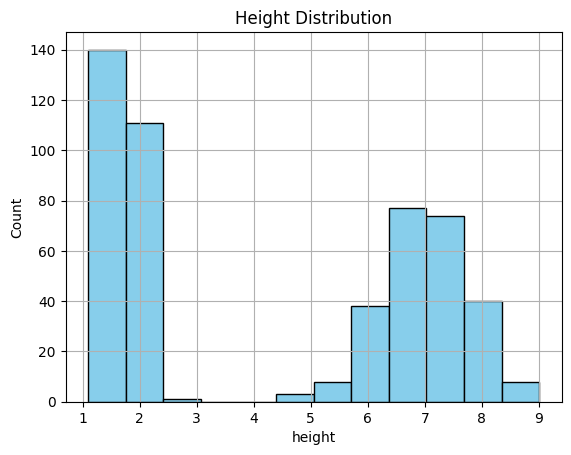

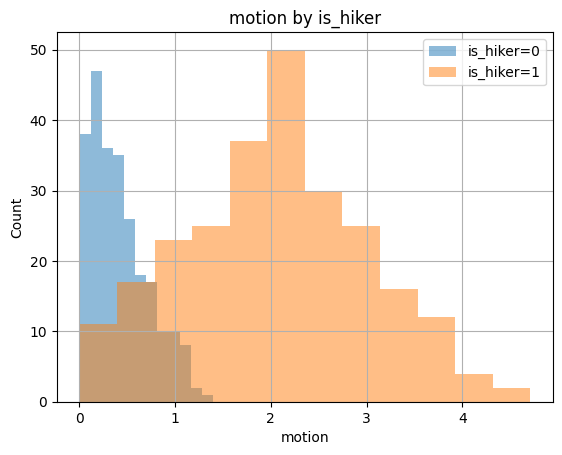

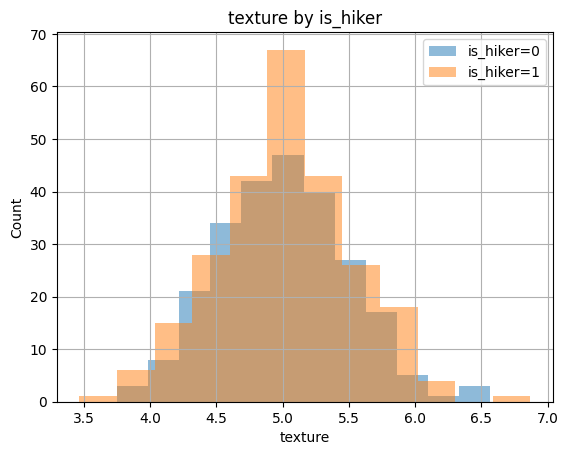

In [13]:
import numpy as np
import pandas
!pip install statsmodels
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/graphing.py
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/hiker_or_tree.csv
import matplotlib.pyplot as plt
import sklearn.model_selection

# Load our data from disk
df = pandas.read_csv("hiker_or_tree.csv", delimiter="\t")

# Split into train and test
train, test =  sklearn.model_selection.train_test_split(df, test_size=0.5, random_state=1)

# Define a helper function to plot histograms by class
def plot_histogram_by_group(data, column, group_column, bins=12):
    groups = data[group_column].unique()
    for group in groups:
        subset = data[data[group_column] == group]
        plt.hist(subset[column], bins=bins, alpha=0.5, label=f'{group_column}={group}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'{column} by {group_column}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Histogram for "height"
plt.hist(test["height"], bins=12, color='skyblue', edgecolor='black')
plt.xlabel("height")
plt.ylabel("Count")
plt.title("Height Distribution")
plt.grid(True)
plt.show()

# Multiple histograms for "motion" and "texture" by "is_hiker"
plot_histogram_by_group(test, "motion", "is_hiker", bins=12)
plot_histogram_by_group(test, "texture", "is_hiker", bins=12)

We have three visual features: `height`, `motion`, and `texture`. Our goal here is not to optimize a model, but to explore ROC curves, so we'll work with just one at a time.

Before diving in, take a look at the preceding distributions. We can see that we should be able to use height to separate hikers from trees quite easily. Motion will be slightly more difficult, presumably because trees blow in the wind, and some hikers are found sitting down. Texture seems much the same for hikers and trees.

## A perfect model

What would a perfect ROC look like? If we had a perfectly designed model, it would calculate "0% chance of hiker" when it saw any tree and "100% of hiker" when it saw any hiker. This means that, so long as the decision threshold was > 0% and < 100%, it would have perfect performance. Between these thresholds, the true positive rate would always be 1, and the false positive rate would always be 0. 

Don't worry about the thresholds of exactly 0 and 1 (100%). At 0, we're forcing a model to return a _False_ value and at 1, we're forcing it to return _True_.

It's almost impossible to train a model that is so perfect, but for the sake of learning, let's pretend we've done so, predicting the `is_hiker` label based on `height`.


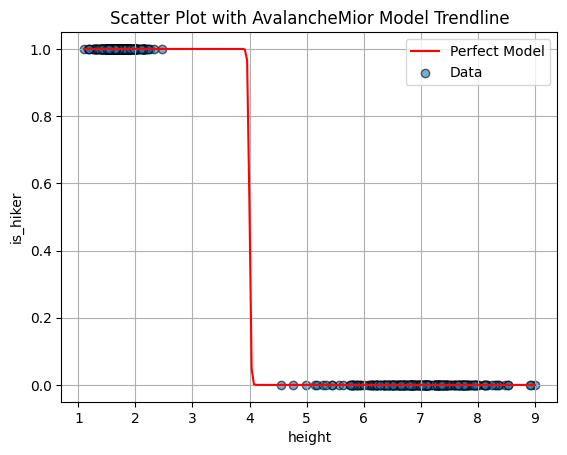

In [14]:
import statsmodels.api

# Create a fake model that is perfect at predicting labels
class AvalancheMiorPerfectModel:
    def predict(self, x):
        # The perfect model believes that hikers are all
        # under 4m tall
        return 1 / (1 + np.exp(80*(x - 4)))
    
model = AvalancheMiorPerfectModel()

# Plot the model
plt.scatter(test["height"], test["is_hiker"], alpha=0.6, label="Data", edgecolor='k')

# Create a range of height values for plotting the model's prediction
x_vals = np.linspace(test["height"].min(), test["height"].max(), 200)
y_vals = model.predict(x_vals)

# Plot the model's prediction (trendline)
plt.plot(x_vals, y_vals, color='red', label="Perfect Model")

plt.xlabel("height")
plt.ylabel("is_hiker")
plt.title("Scatter Plot with AvalancheMior Model Trendline")
plt.legend()
plt.grid(True)
plt.show()

Our red line is our model, and our blue dots are our datapoints. On the y-axis, `0` means tree and `1` means hiker. We can see our perfect model is passing through every single point.

Now we want to make an ROC curve for this perfect model. There are automated ways to do this, but we're here to learn! It's not so hard to do ourselves. We just need to break it down into steps.

Remember than an ROC curve plots the _true positive rate_ (TPR) against the _false positive rate_ (FPR). Let's make a function that can calculate these for us. If you're rusty on what these terms mean, pay attention to the code comments:

In [15]:
def calculate_tpr_fpr(prediction, actual):
    '''
    Calculates true positive rate and false positive rate

    prediction: the labels predicted by the model
    actual:     the correct labels we hope the model predicts
    '''

    # To calculate the true positive rate and true negative rate we need to know
    # TP - how many true positives (where the model predicts hiker, and it is a hiker)
    # TN - how many true negatives (where the model predicts tree, and it is a tree)
    # FP - how many false positives (where the model predicts hiker, but it was a tree)
    # FN - how many false negatives (where the model predicts tree, but it was a hiker)

    # First, make a note of which predictions were 'true' and which were 'false'
    prediction_true = np.equal(prediction, 1)
    prediction_false= np.equal(prediction, 0)

    # Now, make a note of which correct results were 'true' and which were 'false'
    actual_true = np.equal(actual, 1)
    actual_false = np.equal(actual, 0)

    # Calculate TP, TN, FP, and FN
    # The combination of sum and '&' counts the overlap
    # For example, TP calculates how many 'true' predictions 
    # overlapped with 'true' labels (correct answers)
    TP = np.sum(prediction_true  & actual_true)
    TN = np.sum(prediction_false & actual_false)
    FP = np.sum(prediction_true  & actual_false)
    FN = np.sum(prediction_false & actual_true)

    # Calculate the true positive rate
    # This is the proportion of 'hiker' labels that are identified as hikers
    tpr = TP / (TP + FN)

    # Calculate the false positive rate 
    # This is the proportion of 'tree' labels that are identified as hikers
    fpr = FP / (FP + TN)

    # Return both rates
    return tpr, fpr

print("Ready!")

Ready!


Remember that to make an ROC curve, we calculate TPR and FPR for a wide range of thresholds. We then plot the TPR on the y-axis and the FPR on the x-axis. 

First, let's make a short method that can calculate the TPR and FPR for just one decision threshold.

In [16]:
def assess_model(model_predict, feature_name, threshold):
    '''
    Calculates the true positive rate and false positive rate of the model
    at a particular decision threshold

    model_predict: the model's predict function
    feature_name: the feature the model is expecting
    threshold: the decision threshold to use 
    '''

    # Make model predictions for every sample in the test set
    # What we get back is a probability that the sample is a hiker
    # For example, if we had two samples in the test set, we might
    # get 0.45 and 0.65, meaning the model says there is a 45% chance
    # the first sample is a hiker, and 65% chance the second is a 
    # hiker
    probability_of_hiker = model_predict(test[feature_name])
    
    # See which predictions at this threshold would say hiker
    predicted_is_hiker = probability_of_hiker > threshold

    # calculate the true and false positives rates using our
    # handy method
    return calculate_tpr_fpr(predicted_is_hiker, test.is_hiker)

print("Ready!")

Ready!


Now, we can use it in a loop to create an ROC curve:

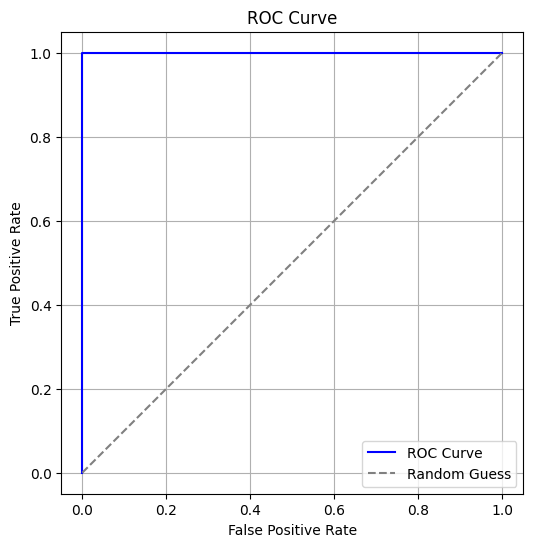

In [17]:
def create_roc_curve(model_predict, feature="height"):
    '''
    This function creates a ROC curve for a given model by testing it
    on the test set for a range of decision thresholds. An ROC curve has
    the True Positive rate on the x-axis and False Positive rate on the 
    y-axis

    model_predict: The model's predict function
    feature: The feature to provide the model's predict function
    '''

    # Calculate what the true positive and false positive rate would be if
    # we had used different thresholds. 

    #  Make a list of thresholds to try
    thresholds = np.linspace(0,1,101)

    false_positive_rates = []
    true_positive_rates = []

    # Loop through all thresholds
    for threshold in thresholds:
        # calculate the true and false positives rates using our
        # handy method
        tpr, fpr = assess_model(model_predict, feature, threshold)

        # save the results
        true_positive_rates.append(tpr)
        false_positive_rates.append(fpr)


    # Graph the result
    plt.figure(figsize=(6, 6))
    plt.plot(false_positive_rates, true_positive_rates, color='blue', label='ROC Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')  # Optional: make the plot square
    plt.show()


# Create an roc curve for our model
create_roc_curve(model.predict)

What are we seeing here?

Except for at a threshold of 0, the model always has a true positive rate of 1. It also always has a false positive rate of 0, unless the threshold has been set to 1. Note that because we've drawn a line, it appears that there are intermediate values (such as a FPR of 0.5) but the line is simply deceiving. If you'd like, comment out `fig.update_traces(mode='lines')` in the above cell and rerun to see points rather than lines. 

Think about it; our model is perfect. Using it, we will always gets all correct answers, putting all points in the top-left corner (unless the threshold is 0 or 1, which effectively mean that we're discarding the model results completely).  

## Worse than chance

As a counter example to understand the ROC curve, lets consider a model that's worse than chance. In fact, this model gets every single answer wrong.

This doesn't happen often in the real world, so again, we'll have to fake this model as well. Let's plot this fake model against our data:

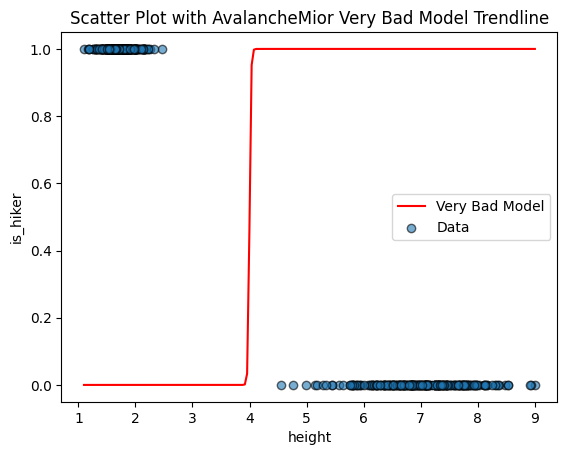

In [18]:
# Create a fake model that gets every single answer incorrect
class AvalancheMiorVeryBadModel:
    def predict(self, x):
        # This model thinks that all people are over 4m tall 
        # and all trees are shorter
        return 1 / (1 + np.exp(-80*(x - 4)))

model = AvalancheMiorVeryBadModel()

# Plot the model
plt.scatter(test["height"], test["is_hiker"], alpha=0.6, label="Data", edgecolor='k')

# Create a range of height values and get the model's predictions
x_vals = np.linspace(test["height"].min(), test["height"].max(), 200)
y_vals = model.predict(x_vals)

# Plot the model's prediction trendline
plt.plot(x_vals, y_vals, color='red', label="Very Bad Model")

plt.xlabel("height")
plt.ylabel("is_hiker")
plt.title("Scatter Plot with AvalancheMior Very Bad Model Trendline")
plt.legend()

As you can see, the red line (model) goes the wrong direction! How will this look on an ROC curve?

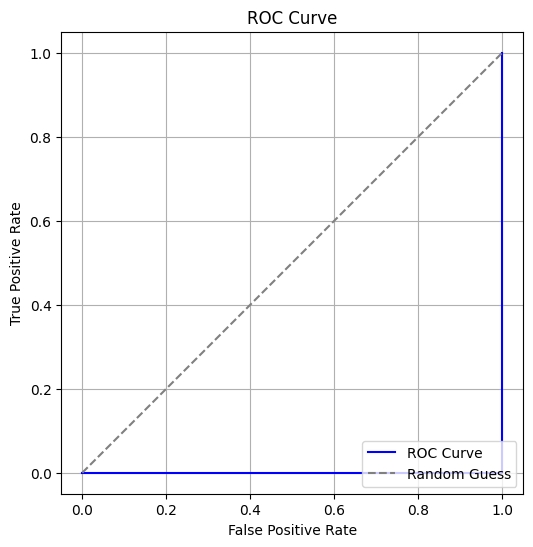

In [19]:
# run our code to create the ROC curve
create_roc_curve(model.predict)

It's the opposite of the perfect model. Rather than the line reaching the top left of the graph, it reaches the bottom right. This means that the TPR is always 0; it gets nothing right at all. In this particular example, it also always has a false positive rate of 1, so long as the threshold is less than 1.

## A model no better than chance

The previous two models we've seen are very unusual. We've learned, though, that we'd like the curve to be as close to the top left of the graph as possible.

What would a model look like that does no better than chance? Let's have a look by trying to fit a model to our texture feature. We know this won't work well, because we've seen that hikers and trees have the same range of image textures. 

Optimization terminated successfully.
         Current function value: 0.693068
         Iterations 3


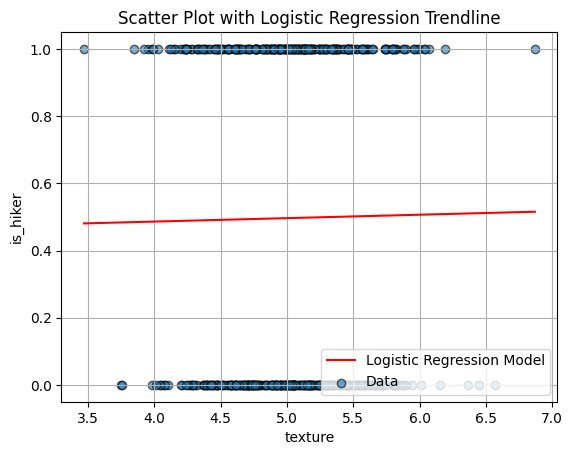

In [20]:
import statsmodels.api

# This is a helper method that reformats the data to be compatible
# with this particular logistic regression model 
prep_data = lambda x:  np.column_stack((np.full(x.shape, 1), x))

# Train a logistic regression model to predict hiker based on texture
model = statsmodels.api.Logit(train.is_hiker, prep_data(train.texture)).fit()

# Plot the model
plt.scatter(test["texture"], test["is_hiker"], alpha=0.6, label="Data", edgecolor='k')

# Create a smooth range of texture values for the trendline
x_vals = np.linspace(test["texture"].min(), test["texture"].max(), 200)
y_vals = model.predict(prep_data(x_vals))

# Plot the logistic regression model's predicted probabilities
plt.plot(x_vals, y_vals, color='red', label="Logistic Regression Model")

plt.xlabel("texture")
plt.ylabel("is_hiker")
plt.title("Scatter Plot with Logistic Regression Trendline")
plt.legend()
plt.grid(True)
plt.show()

Our model isn't very good. It doesn't pass through a single data point and probably will do no better than chance. This seems extreme, but when we work with more complicated problems, sometimes it can be hard to find any real pattern in the data. What does this look like on an ROC curve?

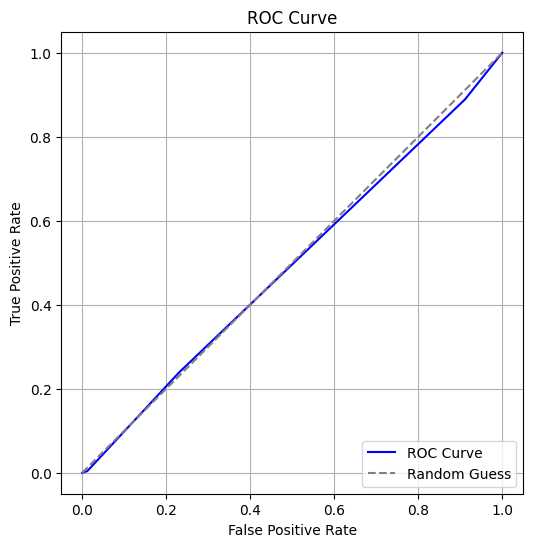

In [21]:
# run our code to create the ROC curve
create_roc_curve(lambda x: model.predict(prep_data(x)), "texture")

It's a diagonal line! Why?

Remember that the model couldn't find a way to reliably predict the label from the feature. It is making a range of predictions, but they're essentially guesswork. 

If we have a threshold of 0.5, about half of our probabilities will be above the threshold, meaning that about half of our predictions are `hiker`. Half of the labels are also hiker, but there's no correlation between the two. This means we'll get about half the predicted `hiker` labels correct (TPR = 0.5). We'll also get about half the predicted `hiker` labels wrong (FPR = 0.5).

If we increased the threshold to 0.8, it would predict _hiker_ 80% of the time. Again, because this is random, it would identify about 80% of the hikers correctly (by chance), and but also 80% of the trees as hikers.

If we continued this approach for all thresholds, we'd achieve a diagonal line.

## A realistic model

In the real world, we typically achieve models that perform somewhere between between pure chance (a diagonal line) and perfectly (a line that touches the top left corner).

Let's finally build a more realistic model. We'll try to predict whether a sample is a hiker or not based on motion. Our model should do OK, but it won't be perfect. This is because hikers sometimes sit still (like trees) and trees sometimes blow in the wind (moving, like a hiker).

Optimization terminated successfully.
         Current function value: 0.260202
         Iterations 8


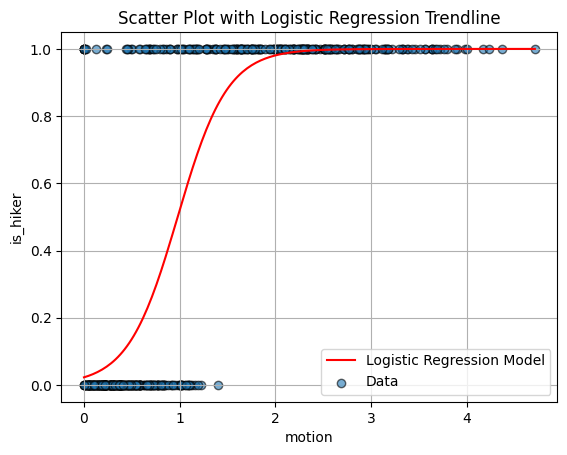

In [22]:
import statsmodels.api

# Train a logistic regression model to predict hiker based on motion
model = statsmodels.api.Logit(train.is_hiker, prep_data(train.motion), add_constant=True).fit()

# Plot the model
plt.scatter(test["motion"], test["is_hiker"], alpha=0.6, label="Data", edgecolor='k')

# Generate smooth range of motion values for plotting the trendline
x_vals = np.linspace(test["motion"].min(), test["motion"].max(), 200)

# Predict probabilities using the trained model
y_vals = model.predict(prep_data(x_vals))

# Plot the logistic regression trendline
plt.plot(x_vals, y_vals, color='red', label="Logistic Regression Model")

plt.xlabel("motion")
plt.ylabel("is_hiker")
plt.title("Scatter Plot with Logistic Regression Trendline")
plt.legend()
plt.grid(True)
plt.show()

The model (red line) seems sensible, though we know sometimes it will get answers wrong.

Now, let's look at the ROC curve:

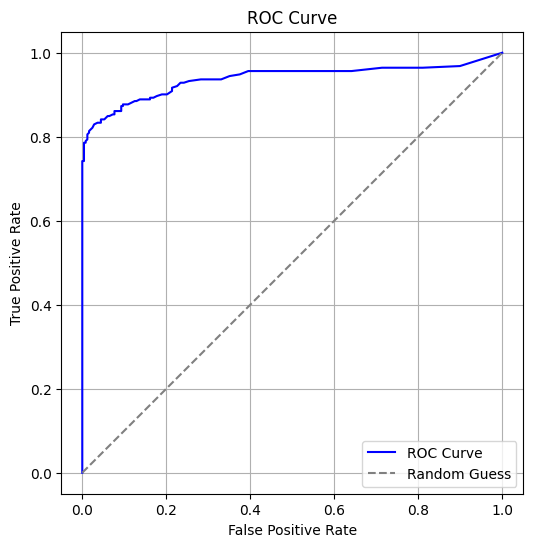

In [23]:
create_roc_curve(lambda x: model.predict(prep_data(x)), "motion")

We can see the curve bulging toward the top left corner, meaning it's working much better than chance.

This is a fairly typical ROC curve for an "easy" machine-learning problem like this. Harder problems often show the line much more similar to a diagonal line.

By contrast, if we ever came across a line that bulged the opposite direction (to the bottom right), we'd know we're doing worse than chance, and something is deeply wrong.


## Summary

We got through it! ROC curves can seem difficult at first, particularly due to the terminology with respect to True and False positives. We built one from scratch here to get a feel for how they're working inside. If you found that tough, read through again slowly, and experiment with some of the functions we made. Don't fret; we normally can use existing libraries to do most of this work for us.

The most important thing to remember with these curves is that we'd like our line to be as close to the top-left of the graph as possible. A model that can do this is correctly identifying the target (such as hikers) most of the time, without falsely identifying the target (labelling trees as hikers) very often.
